<a href="https://colab.research.google.com/github/Hansanghyun-github/simple_VIT/blob/sub/simple_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simple VIT

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from einops import rearrange 
import matplotlib.pyplot as plt

In [ ]:
# transformer encoder의 residual connection
class Residual(nn.Module):
  def __init__(self, fn): 
    super().__init__()
    self.fn = fn 

  def forward(self, x):
    return self.fn(x) + x

In [ ]:
# transformer encoder의 layer normalization
class PreNorm(nn.Module): 
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn 

  def forward(self, x):
    return self.fn(self.norm(x))

In [ ]:
# transformer encoder의 MLP layer
class FeedForward(nn.Module):
  def __init__(self, dim, hidden_dim, dropout=0.):
    super().__init__() 
    self.net = nn.Sequential(
        nn.Linear(dim, hidden_dim), 
        nn.GELU(), 
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim), 
        nn.Dropout(dropout)
    )

  def forward(self, x): 
    return self.net(x)

# Multi-Head Self-Attention layer
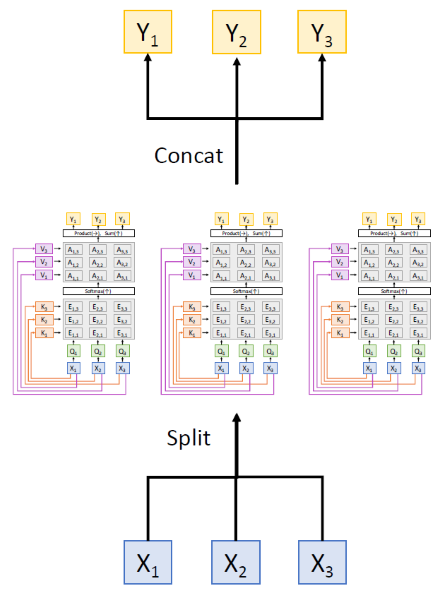

In [ ]:
# transformer encoder의 Multi-Head Self-Attention
class Attention(nn.Module): 
  def __init__(self, dim, heads=8, dropout=0.):
    super().__init__()
    self.heads = heads 
    self.scales = heads ** (-0.5)

    self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
    self.to_out = nn.Sequential(
        nn.Linear(dim, dim), 
        nn.Dropout(dropout)
    )

  def forward(self, x):
    # x의 shape은 (batch, n, dim)
    b, n, _, h = *x.shape, self.heads

    # input vector를 이용해서 query, key, value vector 생성
    # to_qkv 함수를 통해 (batch, n, dim) -> (batch, n, 3*dim)
    # chunk 함수를 통해 (batch, n, 3*dim) -> (batch, n, dim)이 3개인 tuple 형태
    qkv = self.to_qkv(x).chunk(3, dim=-1)

    # 각각의 vector를 head 만큼 split
    # (batch, n, dim) -> (batch, head, n, dim/head)
    q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

    # compute similarity (scaled dot product) (batch와 head를 유지하면서 행렬곱 진행)
    # (batch, head, i, d), (batch, head, j, d) -> (batch, head, i, j) // (i는 query의 개수, j는 key의 개수)
    dots = torch.einsum("bhid, bhjd->bhij", q, k) * self.scales

    # compute attention weights
    # (batch, head, i, j)
    attn = dots.softmax(dim=-1)

    # compute output vector (batch와 head 유지하면서 행렬곱 진행)
    # (batch, head, i, j), (batch, head, i, d) -> (batch, head, i, d)
    out = torch.einsum("bhij,bhjd->bhid", attn, v)

    # split했던 head들을 concat
    # (batch, head, i, d) -> (batch, i(=n), head * d (=dim))
    out = rearrange(out, "b h n d -> b n (h d)")

    # Linear layer
    # (batch, n, dim) -> (batch, n, dim)
    out = self.to_out(out)
    return out

In [ ]:
# transformer encoder
class Transformer(nn.Module):
  def __init__(self, dim, depth, heads, mlp_dim, dropout):
    super().__init__()
    self.layers = nn.ModuleList([])

    # depth만큼 transformer block 쌓음
    for _ in range(depth):
      self.layers.append(nn.ModuleList([
                                        Residual(PreNorm(dim, Attention(dim, heads=heads, dropout=dropout))), 
                                        Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
      ]))

  def forward(self, x):
    for attn, ff in self.layers:
      x = attn(x) # LayerNorm -> Attention -> Residual_connection
      x = ff(x)   # LayerNorm -> MLP_Layer -> Residual_connection
    return x

# VIT layer
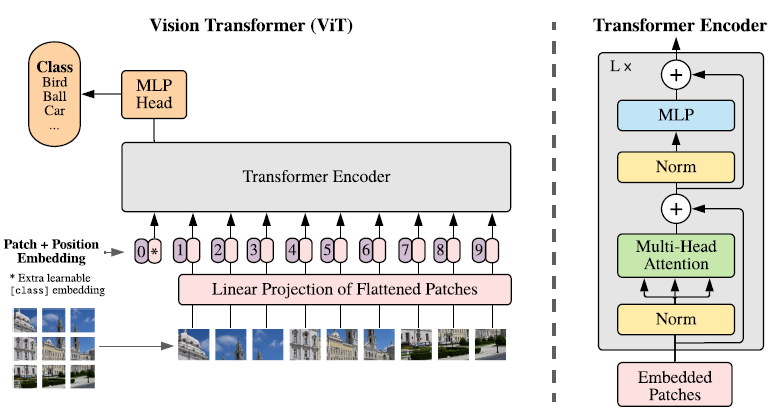

In [ ]:
MIN_NUM_PATCHES = 16
class ViT(nn.Module): 
  def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3, dropout=0., emb_dropout=0.):
    super().__init__()
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size**2 

    self.patch_size = patch_size 

    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
    self.patch_to_embedding = nn.Linear(patch_dim, dim, bias=False)
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    self.dropout = nn.Dropout(emb_dropout)

    self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

    self.to_cls_token = nn.Identity()

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(dim), 
        nn.Linear(dim, mlp_dim), 
        nn.GELU(), 
        nn.Dropout(dropout), 
        nn.Linear(mlp_dim, num_classes)
    )

  def forward(self, img):
    # img shape = (batch size, channel, height, width)

    p = self.patch_size
    
    # 이미지를 패치로 자름, 각 패치를 flatten(1-Dimension) 하게 만듬
    # (batch size, channel, height, width) -> (batch size, number of patch, patch_dim)
    x = rearrange(img, "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=p, p2=p)
    
    # patch embedding
    # (batch size, number of patch, patch_dim) -> (batch size, number of patch, dim)
    x = self.patch_to_embedding(x)
    b, n, _ = x.shape

    # class token embedding vector를 batch size만큼 확장
    # (batch size, 1, dim)
    cls_tokens = self.cls_token.expand(b, -1, -1)

    # x 맨 앞에 cls_tokens 붙힘
    # (batch size, number of patch, dim) -> (batch size, number of patch + 1, dim)
    x = torch.cat((cls_tokens, x), dim=1)

    # x에 pos_embedding 더해줌
    # shape 같음
    x += self.pos_embedding[:, :(n+1)]
    x = self.dropout(x)

    # trnasformer encoder layer
    # (batch size, number of patch + 1, dim) -> (batch size, number of patch + 1, dim)
    x = self.transformer(x)

    # x 맨앞의 head(class token embedding vector) 추출
    # (batch size, number of patch + 1, dim) -> (batch size, dim)
    x = self.to_cls_token(x[:, 0])

    # mlp layer를 통해 output 구함
    # (batch size, dim) -> (batch size, class size(10))
    return self.mlp_head(x)

In [ ]:
# device 변수를 보고 cpu쓸지 cuda(gpu)쓸지 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [ ]:
net = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)
net = net.to(device)

In [ ]:
# pytorch_model_summary 라이브러리를 통해 해당 모델의 구조 확인
!pip install pytorch_model_summary
import pytorch_model_summary

print(pytorch_model_summary.summary(net, torch.zeros(64,3,32,32).to(device), show_input=True))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1        [64, 64, 48]          24,576          24,576
         Dropout-2       [64, 65, 512]               0               0
     Transformer-3       [64, 65, 512]       9,458,688       9,458,688
        Identity-4           [64, 512]               0               0
       LayerNorm-5           [64, 512]           1,024           1,024
          Linear-6           [64, 512]         262,656         262,656
            GELU-7           [64, 512]               0               0
         Dropout-8           [64, 512]               0               0
          Linear-9           [64, 512]           5,130           5,130
Total params: 9,752,074
Trainable params: 9,752,074
Non-trainable params: 0
-------------------------------------------

# 학습에 진행될 하이퍼파라미터와 Dataset

In [ ]:
# hyperparameter

lr = 1e-4           # learning rate
bs = 128            # train dataset의 batch size
n_epochs = 50       # 학습할 에폭의 값


In [ ]:
# train dataset dataloader
transform_train = transforms.Compose([
                                     # 이미지를 첫번째 인자의 사이즈로 자름, padding 크기만큼 의미없는 pixel(값 0) 채움
                                     transforms.RandomCrop(32, padding=4),
                                      
                                     # 50% 확률로 이미지를 수평으로 뒤집는다
                                     transforms.RandomHorizontalFlip(),
                                     
                                     # 데이터 type을 tensor로 변환
                                     transforms.ToTensor(),
                                      
                                     # 값들을 normalize 해줌 / 첫번째 인자는 mean, 두번째 인자는 std / 괄호안의 수의 개수는 채널의 수(CIFAR10의 data는 채널이 3개)
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)

#############################################################################################################################

# test dataset dataloader
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


# CIFAR-10의 label들
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Loss, optimizer, scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-3*1e-5, factor=0.1)

# train, test 함수

In [ ]:
def train():
  net.train()
  train_loss = 0

  for batch_idx, (inputs, targets) in enumerate(trainloader):
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  return train_loss

In [ ]:
def test():
  net.eval() 
  test_loss = 0 
  correct = 0 
  total = 0 

  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader): 
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      test_loss += loss.item() 
      _, predicted = outputs.max(1)
      total += targets.size(0) 
      correct += predicted.eq(targets).sum().item()
      

  scheduler.step(test_loss)
  acc = 100. * correct/total

  print("Accuracy: {}".format(acc))
  return test_loss, acc

# 학습진행

In [ ]:
len_trainset = len(trainset)
len_testset = len(testset)

list_train_loss = []
list_test_loss = []
list_acc = []

for epoch in range(n_epochs):
  print('\nEpoch: %d' % epoch)
  train_loss = train()
  val_loss, val_acc = test()

  list_train_loss.append(train_loss/len_trainset)
  list_test_loss.append(val_loss/len_testset)
  list_acc.append(val_acc)



Epoch: 0
Accuracy: 44.45

Epoch: 1
Accuracy: 51.16

Epoch: 2
Accuracy: 54.32

Epoch: 3
Accuracy: 55.86

Epoch: 4
Accuracy: 57.19

Epoch: 5
Accuracy: 58.85

Epoch: 6
Accuracy: 60.91

Epoch: 7
Accuracy: 61.18

Epoch: 8
Accuracy: 62.49

Epoch: 9
Accuracy: 63.18

Epoch: 10
Accuracy: 64.78

Epoch: 11
Accuracy: 65.65

Epoch: 12
Accuracy: 66.59

Epoch: 13
Accuracy: 66.53

Epoch: 14
Accuracy: 66.76

Epoch: 15
Accuracy: 67.75

Epoch: 16
Accuracy: 68.34

Epoch: 17
Accuracy: 69.5

Epoch: 18
Accuracy: 70.29

Epoch: 19
Accuracy: 70.38

Epoch: 20
Accuracy: 69.97

Epoch: 21
Accuracy: 70.69

Epoch: 22
Accuracy: 71.47

Epoch: 23
Accuracy: 71.72

Epoch: 24
Accuracy: 72.33

Epoch: 25
Accuracy: 72.93

Epoch: 26
Accuracy: 72.75

Epoch: 27
Accuracy: 72.78

Epoch: 28
Accuracy: 73.14

Epoch: 29
Accuracy: 74.03

Epoch: 30
Accuracy: 73.74

Epoch: 31
Accuracy: 74.02

Epoch: 32
Accuracy: 74.36

Epoch: 33
Accuracy: 74.81

Epoch: 34
Accuracy: 74.62

Epoch: 35
Accuracy: 75.24

Epoch: 36
Accuracy: 75.54

Epoch: 37
A

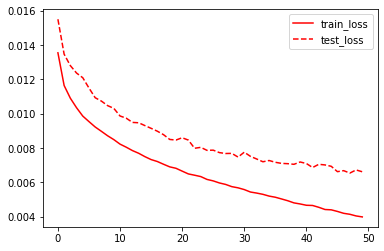

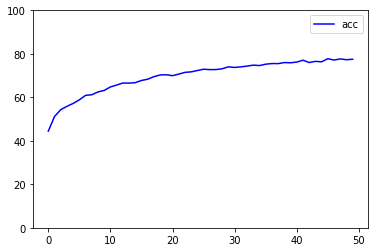

In [ ]:
%matplotlib inline 
plt.plot(list_train_loss, label = "train_loss", color = 'red')
plt.plot(list_test_loss, label = "test_loss", color = 'red', linestyle = "--")
plt.legend(loc = 0)
plt.show()
plt.plot(list_acc, label = "acc", color = 'blue')
plt.ylim(0,100)
plt.legend(loc = 0)
plt.show()

# test data의 label과 output 비교


In [ ]:
def my_test(x):
  net.eval() 

  with torch.no_grad():
    outputs = net(x)
    _, predicted = outputs.max(1)

  return predicted

label: deer
predicted: deer



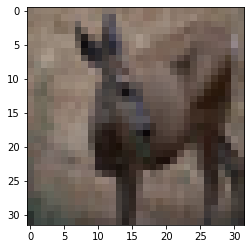

In [ ]:
import random
######### 0 ~ 9999 ###############
#num = 10
num = random.randint(0,9999) # 0에서 9999사이의 랜덤한 값 받음
##################################

compare_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=False)
img, _ = compare_set[num]

x, label = testset[num]
x = x.unsqueeze(dim=0).to(device)

predicted = my_test(x)

print('label:', classes[label])
print('predicted:', classes[predicted])
plt.imshow(img)
print()

# 학습된 모델 드라이브에 저장, 업로드

In [ ]:
# drive.mount를 통해 코랩과 내 계정의 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
# 드라이브가 잘연동됐는지 확인
!ls /content/gdrive/MyDrive

'Colab Notebooks'       seq2seq_attention.ipynb   Untitled0.ipynb
 자연어처리실습.ipynb  'seq2seq with attention'   Untitled1.ipynb
 notebook	        simple_VIT.pt		  vit_tutorial.ipynb


In [ ]:
# 모델을 드라이브에 저장
model_save_name = 'simple_VIT.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(net.state_dict(), path)

In [ ]:
# 드라이브에 있는 모델을 업로드
net.load_state_dict(torch.load(path))

<All keys matched successfully>